# Latent Dirichlet Allocation for Topic Analysis

Performs LDA on lit review abstracts for SGSMA.  Both term frequency and term frequency/inverse document frequency (TFIDF) are explored.

# Imports

In [1]:
%matplotlib notebook
import csv
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings('ignore')

# Read in doc metadata

In [2]:
doc_lookup = {}
with open("data/lit-review-doc-metadata.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        doc_lookup[row["Document Title"]] = row

print(len(doc_lookup.keys()))

9734


# Filter docs

In [3]:
not_found = 0
with open("data/lit-review-categories.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["Document Title"] in doc_lookup:
            doc_lookup[row["Document Title"]]["Label"] = row["Domain"]
        else:
            not_found += 1

print("Missing docs: {}".format(not_found))

ignore = ("", "Overview", "Exclude")
docs = [d for d in doc_lookup.values() if "Label" in d and d["Label"] not in ignore] 
print("Filtered docs: {}".format(len(docs)))

corpus = [d["Abstract"] for d in docs]

Missing docs: 296
Filtered docs: 6413


# Create and Fit LDA model

In [4]:
# params
no_topics = 50
no_features = 1000

# vectorize words
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=no_features, stop_words='english', ngram_range=(1,3))
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

# create separate tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


# Create/fit models
lda_tf = LatentDirichletAllocation(
    n_components=no_topics, 
    random_state=0).fit(tf)

lda_tfidf = LatentDirichletAllocation(
    n_components=no_topics, 
    random_state=0).fit(tfidf)

Save model and related data to disk for separate analysis

In [5]:
joblib.dump({"model": lda_tf, "dtm": tf, "vectorizer": tf_vectorizer, "docs": docs}, 'lda_tf_review.joblib') 

['lda_tf_review.joblib']

# Display top words per topic

In [6]:
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}: {}".format(
            topic_idx,
            " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        ))

## Term Frequency

In [7]:
display_topics(lda_tf, tf_feature_names, no_top_words)

Topic 0: measurement units measurement units phasor phasor measurement units phasor measurement model power dynamic models
Topic 1: bus ieee proposed 14 method placement optimal ieee 14 test observability
Topic 2: parameters parameter measurements errors pmu estimation identification pmu measurements measurement error
Topic 3: islanding time real real time actions cascading based power detection risk
Topic 4: fault location algorithm fault location proposed line proposed algorithm faults using based
Topic 5: data detection event synchrophasor events analysis time pmu data paper synchrophasor data
Topic 6: standard synchrophasor ieee 118 c37 c37 118 measurement pmu performance test
Topic 7: power flow power flow network analysis model power network based simulation results
Topic 8: fault detection faults proposed protection technique scheme fault detection current using
Topic 9: real time real time hardware simulator simulation algorithm platform developed software
Topic 10: sampling me

## Term Frequency / Inverse Document Frequency

In [8]:
display_topics(lda_tfidf, tfidf_feature_names, no_top_words)

Topic 0: zone failures field feeder feedback features feature feasibility faults fault location
Topic 1: hierarchical zone failure feeder feedback features feature feasibility faults fault location
Topic 2: zone failures field feeder feedback features feature feasibility faults fault location
Topic 3: virtual lead zone failures feeder feedback features feature feasibility faults
Topic 4: oscillations oscillation self known detecting control systems caused positioning gps authors
Topic 5: data pmu data synchrophasor synchrophasor data event pmu spectral samples synchrophasor measurements detection
Topic 6: sensor sensors factors individual wireless faster failure failures false fast
Topic 7: shedding load shedding load scheme frequency schemes adaptive protection local uncertainties
Topic 8: iec iec 61850 61850 protective c37 118 c37 individual substation feasibility fault detection
Topic 9: closed closed loop loop delays delay stability analysis feedback control scheme margin modeled
T

# Find predictions for training data

In [9]:
tf_predictions = np.argmax(lda_tf.transform(tf), axis=1)
tfidf_predictions = np.argmax(lda_tfidf.transform(tfidf), axis=1)
(tf_predictions.shape, tfidf_predictions.shape)

((6413,), (6413,))

In [10]:
def plot_topic_distribution(predictions, title):
    fix, ax = plt.subplots()
    ax.set_xlabel("topics")
    ax.set_ylabel("document count")
    ax.set_title(title)

    series = pd.Series(predictions)
    _ = series.hist(bins=no_topics, ax=ax)

<IPython.core.display.Javascript object>


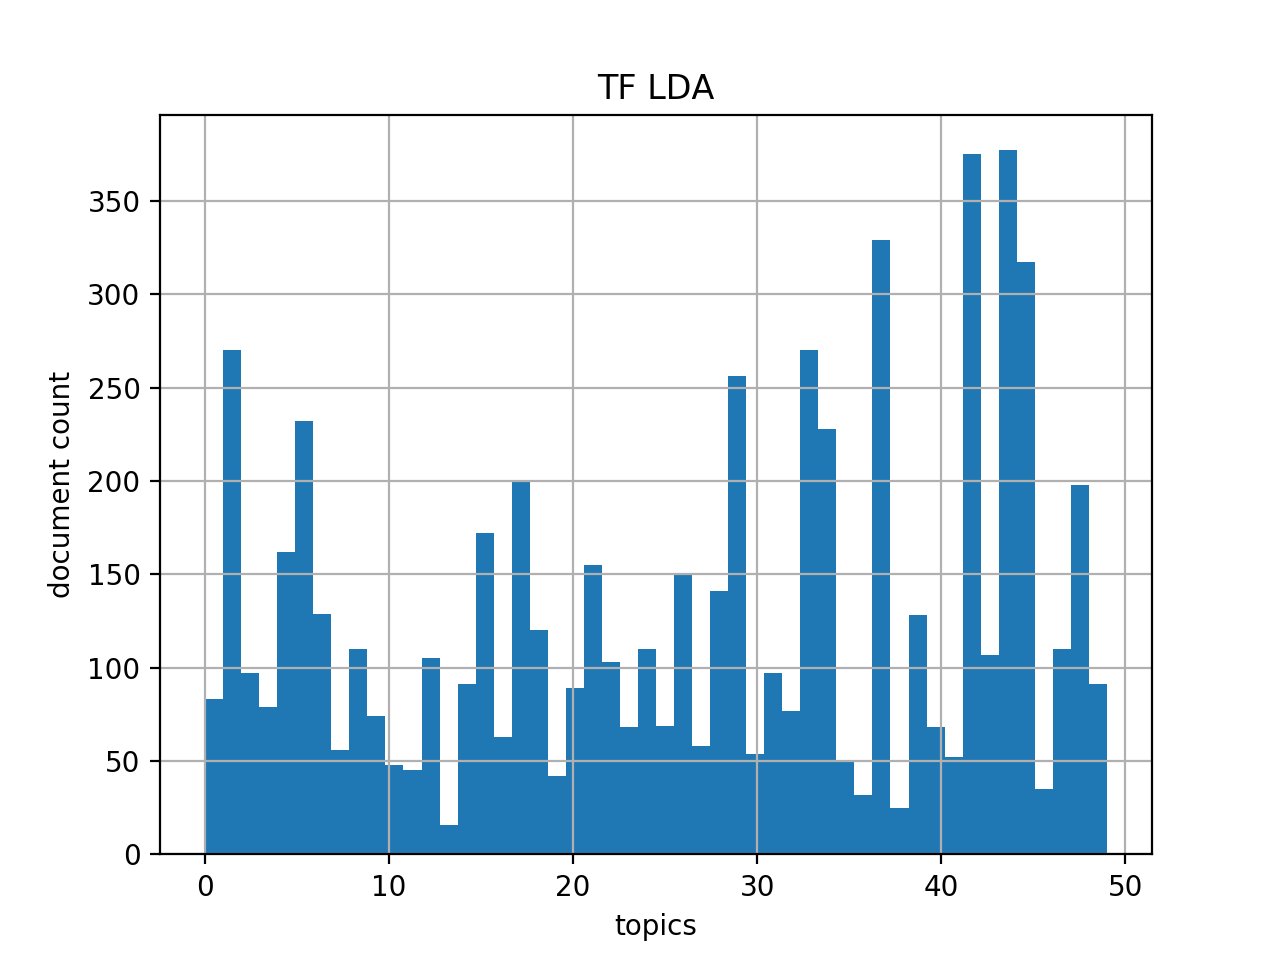

In [11]:
plot_topic_distribution(tf_predictions, "TF LDA")

<IPython.core.display.Javascript object>


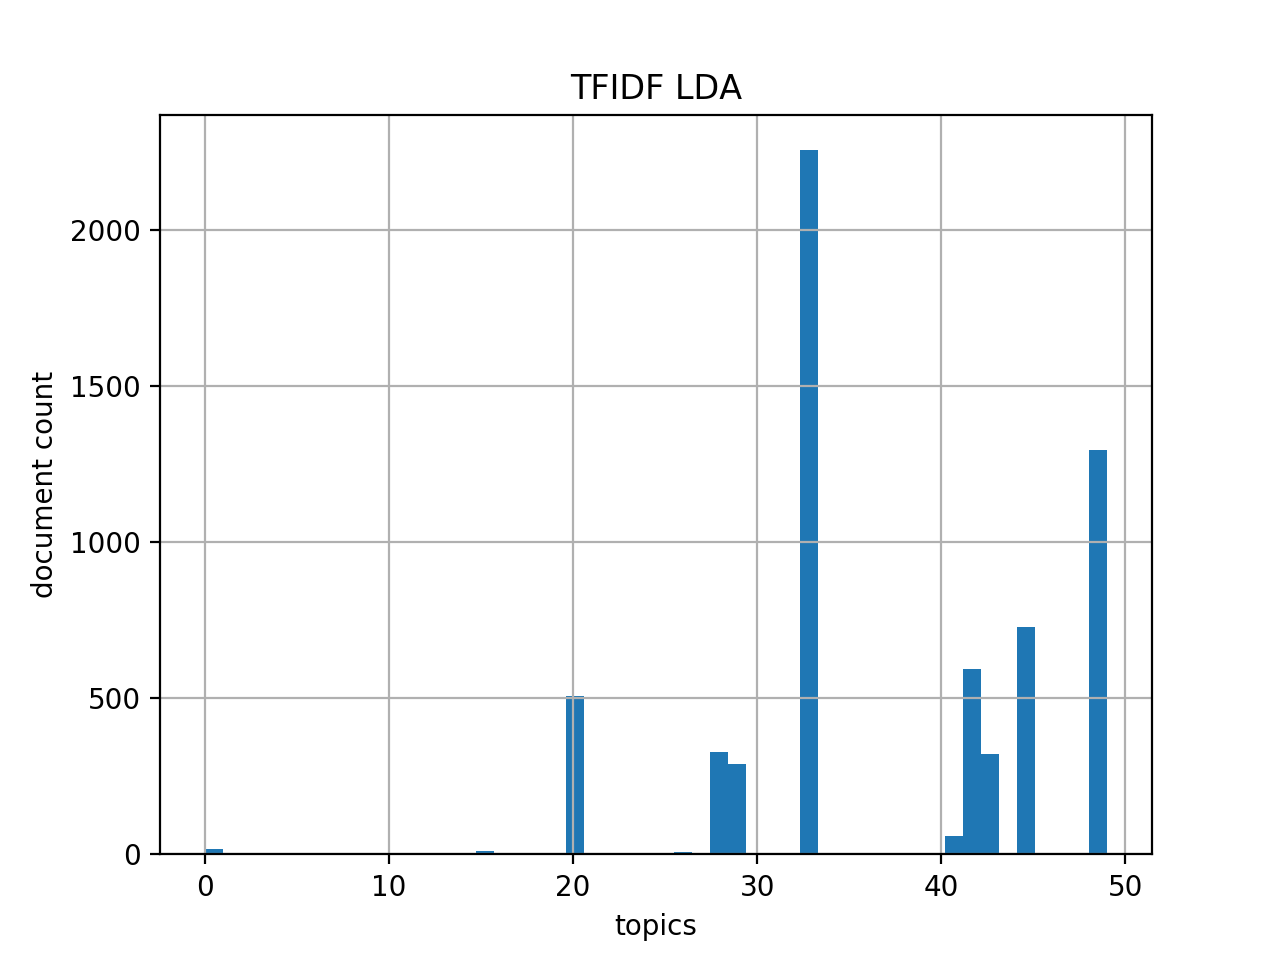

In [12]:
plot_topic_distribution(tfidf_predictions, "TFIDF LDA")

# Interactive Topic Explorer

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, Output
from IPython.display import display, clear_output

## TF Explorer

In [14]:
tf_freq = FreqDist(tf_predictions)
out1 = Output()

def f_tf(topic):
    indexes = np.where(tf_predictions==topic)[0]
    text = []
    with out1:
        clear_output()
        for idx in indexes:
            print("- {}".format(docs[idx]["Document Title"]))
        

interact(f_tf, topic=sorted([("Topic {}: {} docs".format(k, v), k) for k, v in tf_freq.items()], key=lambda d: d[1]))
display(out1)

interactive(children=(Dropdown(description='topic', options=(('Topic 0: 83 docs', 0), ('Topic 1: 270 docs', 1)…

Output()

## TFIDF Explorer

In [15]:
tfidf_freq = FreqDist(tfidf_predictions)
tfidf_out = Output()

def tfidf_f(topic):
    indexes = np.where(tfidf_predictions==topic)[0]
    with tfidf_out:
        clear_output()
        for idx in indexes:
            print("- {}".format(docs[idx]["Document Title"]))
        

interact(tfidf_f, topic=sorted([("Topic {}: {} docs".format(k, v), k) for k, v in tfidf_freq.items()], key=lambda d: d[1]))
display(tfidf_out)

interactive(children=(Dropdown(description='topic', options=(('Topic 0: 16 docs', 0), ('Topic 15: 12 docs', 15…

Output()

## Topic Word Visual Explorer

In [16]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [17]:
# MMDS and TSNE can be used for plotting rather than the default PCoA
pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
45    -0.104649  0.253431       1        1  4.398159
42    -0.028192 -0.076893       2        1  3.973678
1     -0.182978 -0.326026       3        1  3.963801
37    -0.255266 -0.164937       4        1  3.683418
44     0.010318 -0.172389       5        1  3.651051
29     0.217301  0.087198       6        1  3.477035
48    -0.150339 -0.151971       7        1  3.437120
5     -0.051836  0.060395       8        1  3.214595
33     0.192994  0.149389       9        1  2.996527
21    -0.037551  0.323120      10        1  2.927302
34     0.147377 -0.351639      11        1  2.770889
17     0.325487  0.115377      12        1  2.649796
26     0.088929  0.252291      13        1  2.505880
35     0.237734  0.348388      14        1  2.147845
47    -0.092090 -0.296158      15        1  2.110800
15    -0.273075  0.115732      16        1  2.085665
24    -0.339320  0.171221      17        1  2.007721
4     -0.339131 -0.067087      18        1  1.991301
12    -0.183852 -0.096912      19        1  1.948700
9      0.019623 -0.400042      20        1  1.922848
16     0.160347 -0.269012      21        1  1.901200
14     0.436483 -0.119194      22        1  1.871985
18     0.367305  0.003004      23        1  1.852649
22    -0.091612 -0.219864      24        1  1.793303
2     -0.264006 -0.057379      25        1  1.720339
20     0.130714 -0.151563      26        1  1.702658
8     -0.369592 -0.001671      27        1  1.640340
23     0.076614 -0.280806      28        1  1.631559
39    -0.250585 -0.257185      29        1  1.619452
0     -0.188360  0.338733      30        1  1.613562
43    -0.177827  0.131971      31        1  1.595505
6     -0.095573  0.384474      32        1  1.592977
28     0.281326 -0.282137      33        1  1.591390
32    -0.168481 -0.012587      34        1  1.498127
49     0.281655 -0.124652      35        1  1.444128
31     0.243838 -0.182818      36        1  1.410635
40     0.121794  0.027887      37        1  1.395151
41    -0.387153  0.083931      38        1  1.370588
3      0.062902  0.122105      39        1  1.300767
7      0.091236 -0.079399      40        1  1.282480
27     0.386588  0.250092      41        1  1.276907
30     0.242220  0.266391      42        1  1.204552
25     0.268270 -0.055383      43        1  1.187044
11    -0.066725 -0.362659      44        1  1.092385
36     0.328247  0.049895      45        1  1.045645
10    -0.155571  0.221167      46        1  0.989560
38     0.089325  0.408107      47        1  0.912786
19     0.150317  0.313514      48        1  0.897187
46    -0.304894  0.306043      49        1  0.856341
13    -0.400287 -0.223495      50        1  0.844668, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
377   Default   3708.000000            grid   3708.000000  30.0000  30.0000
658   Default  11299.000000           power  11299.000000  29.0000  29.0000
332   Default   2402.000000           fault   2402.000000  28.0000  28.0000
909   Default   4790.000000            time   4790.000000  27.0000  27.0000
201   Default   5563.000000            data   5563.000000  26.0000  26.0000
56    Default   2864.000000            area   2864.000000  25.0000  25.0000
705   Default   1794.000000      protection   1794.000000  24.0000  24.0000
847   Default   3417.000000           state   3417.000000  23.0000  23.0000
821   Default   1738.000000           smart   1738.000000  22.0000  22.0000
250   Default   1637.000000    distribution   1637.000000  21.0000  21.0000
645   Default   3501.000000             pmu   3501.000000  20.0000  20.0000
633   Default   3482.000000          phasor   3482.000000  19.0000  19.0000
985   Default   2029.000000            wide   2029.000000  18.0000  18.0000
358   Default   2544.000000       frequency   2544.000000  17

In [19]:
pyLDAvis.sklearn.prepare(lda_tf, tfidf, tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
42    -0.157022  0.042763       1        1  4.563285
44     0.126129 -0.030686       2        1  4.543670
1     -0.185000  0.191549       3        1  4.010982
45     0.320782  0.030171       4        1  3.986342
37     0.242890  0.211649       5        1  3.758536
33    -0.069315 -0.253926       6        1  3.706683
17    -0.004329 -0.335848       7        1  3.341724
5     -0.099658  0.099773       8        1  2.952672
34    -0.207640 -0.242924       9        1  2.818801
29     0.009513 -0.237020      10        1  2.741495
21     0.356692  0.084204      11        1  2.687680
26    -0.246810 -0.108579      12        1  2.423454
15     0.021653  0.351775      13        1  2.333462
48    -0.014843  0.193974      14        1  2.324465
47     0.007383  0.132832      15        1  2.116686
24    -0.311206 -0.228811      16        1  2.076478
4     -0.120148  0.294755      17        1  2.016126
18    -0.150776 -0.328961      18        1  2.005497
28    -0.325145 -0.174527      19        1  1.987084
12     0.001594  0.244385      20        1  1.955036
39     0.249745  0.276948      21        1  1.923002
20    -0.088670 -0.068775      22        1  1.824684
43     0.256307  0.094440      23        1  1.805698
6      0.403449 -0.062768      24        1  1.727233
2      0.161118  0.258212      25        1  1.675482
8     -0.202689  0.287857      26        1  1.663097
32     0.135666  0.171017      27        1  1.641363
35     0.058807 -0.412218      28        1  1.605636
31     0.129476 -0.199453      29        1  1.595304
14     0.137057 -0.422832      30        1  1.539191
40    -0.145939 -0.159666      31        1  1.510025
3     -0.313905 -0.044456      32        1  1.509350
49     0.234479 -0.165033      33        1  1.497496
30    -0.374544  0.096785      34        1  1.486233
23    -0.283735  0.053914      35        1  1.426405
41     0.155994  0.377729      36        1  1.384601
27    -0.458648 -0.051442      37        1  1.339684
16    -0.030712 -0.067171      38        1  1.331780
22     0.120940  0.083400      39        1  1.320939
9     -0.289547  0.265033      40        1  1.257059
11     0.077604  0.317452      41        1  1.207701
10     0.288385 -0.033289      42        1  1.175886
7      0.053706 -0.092164      43        1  1.151628
0      0.414714  0.075055      44        1  1.139570
19     0.229886 -0.312707      45        1  1.074394
25     0.171880 -0.244667      46        1  1.071192
36     0.306792 -0.210907      47        1  1.063886
38    -0.119671 -0.414286      48        1  1.010620
46    -0.371837  0.226270      49        1  0.942926
13    -0.100852  0.441169      50        1  0.747777, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
658   Default  954.000000           power  954.000000  30.0000  30.0000
377   Default  292.000000            grid  292.000000  29.0000  29.0000
332   Default  208.000000           fault  208.000000  28.0000  28.0000
705   Default  159.000000      protection  159.000000  27.0000  27.0000
909   Default  401.000000            time  401.000000  26.0000  26.0000
201   Default  455.000000            data  455.000000  25.0000  25.0000
56    Default  226.000000            area  226.000000  24.0000  24.0000
847   Default  306.000000           state  306.000000  23.0000  23.0000
250   Default  151.000000    distribution  151.000000  22.0000  22.0000
358   Default  231.000000       frequency  231.000000  21.0000  21.0000
645   Default  281.000000             pmu  281.000000  20.0000  20.0000
821   Default  131.000000           smart  131.000000  19.0000  19.0000
633   Default  282.000000          phasor  282.000000  18.0000  18.0000
532   Default  330.000000          method  330.000000  17.0000  17.0000
174   Default  366.000000         control  366.00